# Catch Me If You Can

_**Intruder Detection through Webpage Session Tracking**_

---

---

## Contents

1. [Background](#Background)
1. [Setups](#Setups)
1. [Meet and Greet the Data](#Data)
1. [Model Training](#Model-Training)
    1. [Count vectorizer](#Count-vectorizer)
    1. [Logistic Regression model](#Logistic-Regression-model)

---



## Background

_This notebook has been adapted from multiple notebook submission in [Kaggle: Catch Me If You Can](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview)_

Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

With this dataset, this workshop aim to introduce to you the data science workflow on creating and deploying models as API. AWS provide a service for blablabla...

## Setups

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

### AWS Configuration and S3

In [ ]:
bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Python Packages & Libraries

In [71]:
import warnings
warnings.simplefilter('always')

In [6]:
# Standard library
import os, json, time
from IPython.display import display
from time import strftime, gmtime

# AWS Sagemaker Python API
import sagemaker
from sagemaker.predictor import csv_serializer

In [72]:
# Visualisation library
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

from IPython.display import display_html

In [73]:
# Datascience libraries
import pickle
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

---
## Meet and Greet the Data


The train set train_sessions.csv contains information on user browsing sessions where the features are:

- `site_i` – are ids of sites in this session. The mapping is given with a pickled dictionary site_dic.pkl
- `time_j` – are timestamps of attending the corresponding site
- `target` – whether this session belongs to Alice

The dataset we use is publicly available and was mentioned in the book [A Tool for Classification of Sequential Data]() by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud. Let's begin exploring the data.

In [83]:
PATH_TO_DATA = './data/catch_me_kaggle/'
SEED = 42

path_to_train = os.path.join(PATH_TO_DATA, 'train_sessions.csv')
path_to_test = os.path.join(PATH_TO_DATA, 'test_sessions.csv')

In [18]:
train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=['time1'])

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [25]:
# show the shape of our dataset
print("The shape of training dataset: ", train_df.shape)

The shape of training dataset:  (253561, 21)


By modern standards, it’s a relatively big dataset, with 253561 records, where each record uses 21 attributes to describe the visiting time of a particular site.

The training data set contains the following features:

- `site1` – id of the first visited website in the session
- `time1` – visiting time for the first website in the session
...
- `site10` – id of the tenth visited website in the session
- `time10` – visiting time for the tenth website in the session
- `target` – target variable, possesses value of 1 for Alice's sessions, and 0 for the other users' sessions

User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

Now let's load the websites dictionary and check how it looks like:

In [55]:
# Load websites dictionary
path_to_sitedic = os.path.join(PATH_TO_DATA, 'site_dic.pkl')
with open(path_to_sitedic, 'rb') as input_file:
    site_to_id = pickle.load(input_file)

# Create dataframe for the dictionary
sites_df = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print('Websites total:', sites_df.shape[0])

sites_df.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [57]:
# Invert the site mapping from site to id
id_to_site = {v:k for k,v in site_to_id.items()}
id_to_site[0] = 'unknown'

## Modelling
For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is an Alice's session, and vice versa.

Let us prepare the data, we will take only features `site1`, `site2`, ... , `site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero.

With this basic idea, we can use many models that works great. For the sake of this workshop, we propose the workflow as follows:
1. Transform data into "*Bag of Word*" representation: this representation that highlights frequency of visited site by Alice as well as the intruder with the hope that our next model can discriminate between Alice and the intruder.
2. Classification model: We choose XGBoost algorithm for this example. Feel free to experiment with other algorithms available as well

### Data  Preprocessing

In [58]:
# Transform data into format which can be fed into TfidVectorizer
sites = ['site%d' %i for i in range(1, 11)]

train_sessions = (train_df[sites].fillna(0).astype('int')
                  .apply(lambda row: ' '.join([id_to_site[i] for i in row]), axis=1)
                  .to_list())

test_sessions = (test_df[sites].fillna(0).astype('int')
                 .apply(lambda row: ' '.join([id_to_site[i] for i in row]), axis=1)
                 .to_list())

In [64]:
for line in train_sessions[:5]:
    print("- Sites visited:", line)

- Sites visited: safebrowsing.clients.google.com safebrowsing-cache.google.com unknown unknown unknown unknown unknown unknown unknown unknown
- Sites visited: safebrowsing.clients.google.com safebrowsing-cache.google.com safebrowsing.clients.google.com safebrowsing-cache.google.com unknown unknown unknown unknown unknown unknown
- Sites visited: www.apache.org www.apache.org download.eclipse.org www.apache.org www.apache.org www.webtide.com download.oracle.com javadl-esd-secure.oracle.com www.caucho.com www.apache.org
- Sites visited: www.webtide.com download.oracle.com www.caucho.com download.oracle.com www.webtide.com www.apache.org public.dhe.ibm.com www.webtide.com www.apache.org www.apache.org
- Sites visited: public.dhe.ibm.com jope.ow2.org download.oracle.com public.dhe.ibm.com jope.ow2.org master.dl.sourceforge.net www.apache.org download.eclipse.org www.apache.org public.dhe.ibm.com


In [75]:
# We tell the TfidfVectorizer to split data (the site name) by whitespace 
# so that it doesn't split by dots (the default)
vectorizer = TfidfVectorizer(ngram_range=(1,5), max_features=50000,
                           tokenizer=lambda s: s.split())

In [76]:
# transform sites visit data into "Bag of Words" representation
X_train = vectorizer.fit_transform(train_sessions)
X_test = vectorizer.fit_transform(train_sessions)

In [77]:
y_train = train_df['target'].astype('int').values

These are the basic features - sequences of visited web-sites

In [ ]:
vectorizer.get_feature_names()[:10]

### Time Features Engineering
Here we'll build just a few plots to motivate feature engineering. While competing, you'll need to create much more plots and build more features based on your observations. Take a look at Kernels for this competition, eg. at this "Initial EDA". You can do much more with sites, but let's switch to site visit times.

In [86]:
time_cols = ['time%s' % i for i in range(1, 11)]

In [101]:
# extract the time (hour) of user start activity
train_times, test_times = train_df[time_cols], test_df[time_cols]
session_start_hour = train_times['time1'].apply(lambda time1: time1.hour).values

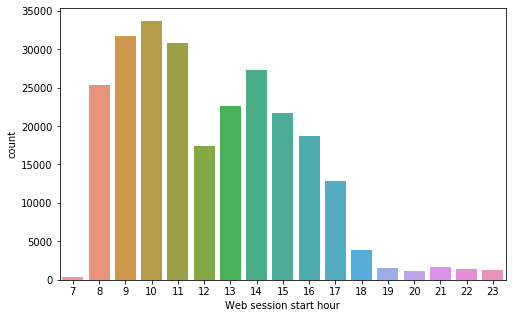

In [107]:
# visualise distribution of internet activity over a day
plt.figure(figsize=(8,5))
sns.countplot(session_start_hour);
plt.xlabel('Web session start hour');

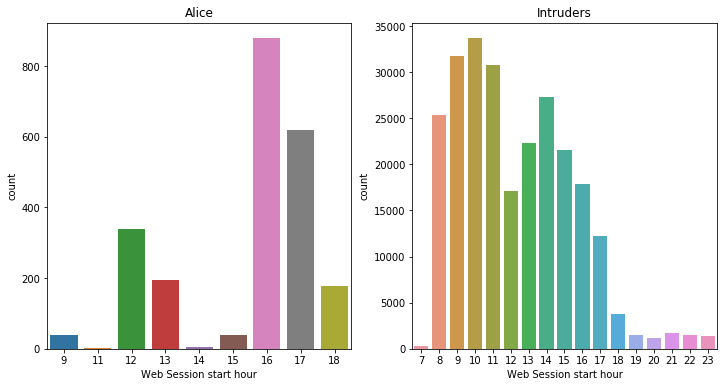

In [97]:
# visualise Alice's internet activity over a day
plt.subplots(1, 2, figsize=(12,6))

plt.subplot(1,2,1)
sns.countplot(session_start_hour[y_train == 1])
plt.title('Alice')
plt.xlabel('Web Session start hour')


plt.subplot(1,2,2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Intruders')
plt.xlabel('Web Session start hour');

Now we can definitely see that Alice mostly prefers 4-5 pm for browsing. We can create a feature that indicates browsing time to `morning`, `day`, `evening`, and `night`. 

Seperators between these times of the day will be arbitrary 0 am, 7 am, 12 am, and 7 pm. Feel free to fine tune the seperator.

In [108]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [112]:
pd.crosstab([morning, day, evening, night], y_train, 
            rownames=['morning', 'day', 'evening', 'night'], colnames=[''])

0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

Let's define a function to add new features. We would also like to experiment whether indicating the hour specifically into our feature can improve or worsen the model performance.

In [125]:
def add_time_features(train_times, sparse_data, add_hour=False):
    session_start_hour = train_times['time1'].apply(lambda time1: time1.hour)
    
    # indicates categorical time of the day
    morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int').values.reshape(-1, 1)
    
    # add the above time feature to main dataframe
    features = [sparse_data, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']
    
    if add_hour:
        # we added the hour indicator, and scale hour dividing by 24
        features.append(session_start_hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
    
    X = hstack(features)
    return X

In [126]:
%%time
# our feature-engineered data
X_train_with_time = add_time_features(train_times, X_train, add_hour=False)
X_test_with_time = add_time_features(train_times, X_test, add_hour=False)

CPU times: user 2.24 s, sys: 19.4 ms, total: 2.25 s
Wall time: 2.25 s


### Model Specification

In [84]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

### Time series splitting

In [129]:
time_split = TimeSeriesSplit(n_splits=10)

### Model Training

In [134]:
def train_and_predict(model, X_train, y_train, cv_split, 
                      scoring='roc_auc'):

    # perform training with cross validation
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=cv_split, n_jobs=4)
    model.fit(X_train, y_train)
    feature_names = vectorizer.get_feature_names() + ['morning', 'day', 'evening', 'night']
    display_html(eli5.show_weights(estimator=model, 
                                   feature_names=feature_names, top=30))

    return cv_scores

In [135]:
cv_scores = train_and_predict(logit, X_train_with_time, y_train, cv_split=time_split)

Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com
